In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import re
#nltk.download('vader_lexicon')

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [2]:
transcripts = "MSDS696/data/ted-talks/transcripts.csv"
main = "MSDS696/data/ted-talks/ted_main.csv"

In [3]:
class SourceData():
    def __init__(self,transcripts_path, main_path):
        self.t = transcripts_path
        self.m = main_path
        self.df_t = pd.read_csv(self.t)
        self.df_m = pd.read_csv(self.m)
        self.df = self._merge_frames()
        
    def _merge_frames(self):
        df_t = self.df_t.copy()
        df_t.drop_duplicates(inplace=True)
        #join tables on 'url'
        df = pd.merge(self.df_m,df_t,how='inner',on='url') 
        return df
        

In [4]:
source = SourceData(transcripts, main)

In [5]:
df = source.df

In [6]:
df.shape

(2464, 18)

In [7]:
class SentimentCalculator():
    def __init__(self,df):
        self.df = df
        self._new_words_dict = {'unconvincing':'unconvinced',
                                'ingenious':'brilliant',
                                'persuasive':'convincing',
                                'longwinded':'boring', 
                                'informative':'enlightening',
                                'jaw-dropping':'astounding'
                                }
        self.talk_scores = self._get_all_talk_scores()
    
    def _str_to_dic_list(self,string_dic_list):
        s = string_dic_list
        d_list = eval(s)
        return d_list 
    
    def _words_not_in_vader_lexicon(self):
        '''
        assumes df has series called 'ratings' and within that
        series is lists of dictionaries as strings

        '''
        df = self.df
        def get_rating_name_set(dic_list):
            rating_names = [d['name'].lower() for d in dic_list]
            return list(set(rating_names))

        def get_series_rating_name_set(rating_series):
            rs = rating_series
            names_all = []
            for ratings_list in rs:
                d_list = self._str_to_dic_list(ratings_list)
                names = get_rating_name_set(d_list)
                names_all.extend(names)
            return list(set(names_all))

        sid = SentimentIntensityAnalyzer()
        names_list = get_series_rating_name_set(df['ratings'])
        bad_names = [n for n in names_list if n not in sid.lexicon.keys()]
        return bad_names
    
    def _get_talk_score(self, ratings_df):
        df = self.df
        new_words = self._new_words_dict
        
        sid = SentimentIntensityAnalyzer()

        r_df = ratings_df
        r_df['name'] = r_df['name'].str.lower()
        r_df.replace({'name':new_words}, inplace=True)
        r_df['base_sentiment_score'] = r_df['name'].map(sid.lexicon)
        score = np.average(r_df['base_sentiment_score'], weights=r_df['count']) 
        return score
    
    def _get_all_talk_scores(self):
        scores = []
        for talk_ratings in self.df['ratings']:
            talk = pd.DataFrame(self._str_to_dic_list(talk_ratings))
            score = self._get_talk_score(talk)
            scores.append(score)

        return scores

In [8]:
sent_calc = SentimentCalculator(df)

In [9]:
df['sentiment_score'] = sent_calc.talk_scores

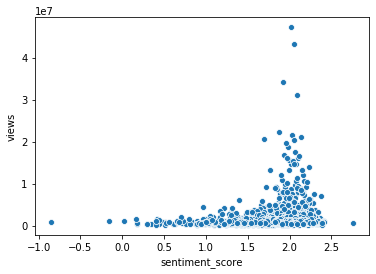

In [10]:
sns.scatterplot(df['sentiment_score'], df['views'])

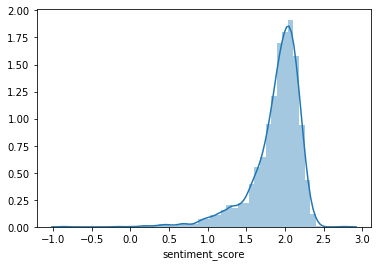

In [11]:
sns.distplot(df['sentiment_score'])

In [12]:
df.corr()['sentiment_score'].sort_values()

duration          -0.061776
comments          -0.035991
num_speaker        0.014938
languages          0.061465
views              0.122768
published_date     0.249722
film_date          0.258322
sentiment_score    1.000000
Name: sentiment_score, dtype: float64

In [13]:
class Tags():
    def __init__(self,df):
        self.df = df.copy()
        self.all_tags = self._get_tag_set()
        self.all_tag_dummies = self._get_tag_dummies_df()
        self.filterd_tag_dummies = self._filter_df_by_correlation()
        
    def _str_to_list(self, string_list):
        s = string_list
        e_list = eval(s)
        return e_list
    
    def _get_tag_set(self):
        tags_list = []
        series = self.df['tags'].copy()
        for tag_list in series:
            lst = self._str_to_list(tag_list)
            tags_list.extend(lst)
        tag_set = set(tags_list)
        return list(tag_set)
    
    def _get_tag_dummies_df(self):
        s = self.df['tags'].apply(self._str_to_list)
        tag_dummies_df = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
        tag_dummies_df['sentiment_score'] = self.df['sentiment_score']
        return tag_dummies_df
    
    def get_tag_score_correlation(self):
        tag_corr= self.all_tag_dummies.corr()['sentiment_score'].sort_values(ascending = False)
        tag_corr= tag_corr.drop(index='sentiment_score')
        return tag_corr
    
    def _filter_df_by_correlation(self,min=-0.04,max=0.04):
        tag_corr = self.get_tag_score_correlation()
        tag_corr_filtered = tag_corr[(tag_corr>=max) | (tag_corr<=min)] 
        cols = list(tag_corr_filtered.index)
        cols.append('sentiment_score')
        filtered_df= self.all_tag_dummies[cols].copy()
        return filtered_df

In [14]:
# a4_dims = (30, 100)
# fig, ax = pyplot.subplots(figsize=a4_dims)
# cahart = sns.barplot(y = tag_corr_asc.index, x = tag_corr_asc)
#pyplot.savefig('corr.pdf')
#chart.set_xticklabels(rotation=45, labels = tag_corr.index)

In [15]:
#sns.distplot(tag_corr_asc, bins = 15)

In [16]:
# a4_dims = (20, 40)
# fig, ax = pyplot.subplots(figsize=a4_dims)
# cahart = sns.barplot(y = tag_corr_asc_filtered.index, x = tag_corr_asc_filtered)
#pyplot.savefig('corr.pdf')
#chart.set_xticklabels(rotation=45, labels = tag_corr.index)

In [114]:
class Transcripts():
    def __init__(self,df):
        self.df = df
        self.words1 = self._distill_text_to_words()
        self._more_stops= self._get_stop_words_by_freq(self.words1)
        self.words2 = self._distill_to_words_with_more_stops()
        self.stems = self._get_stems()
        self.all_stem_dummies = self._get_all_stem_dummies()
        self.filtered_stem_dummies = self._get_filtered_dummies()
        
    def _distill_text_to_words(self, more_stop_words=[]):
        stoplist = stopwords.words('english')
        stoplist.extend(more_stop_words)
        def distill(series):
            text = series.split()
            text = [s.lower() for s in text]
            text = [s for s in text if '(' not in s]
            text = [s.strip('?') for s in text]
            text = [s for s in text if s.isalpha()]
            text = list(set(text).difference(set(stoplist)))
            return text
        words = df['transcript'].map(distill)
            
        return words
    
    def _get_stop_words_by_freq(self,words_Series, min_count = 25,max_count=1000):
        '''
        returns stop words that are outside of min, max
        '''
        def get_all_word_counts(pandas_Series):
            s = pandas_Series
            combined = sum(s,[])
            fdist = nltk.FreqDist(combined)
            counts = fdist.most_common()
            return counts
        
        def get_words_list(counts):
            words = [c[0] for c in counts]
            return words
        
        def slice_word_counts(counts, min_count, max_count):
            sliced = [c[0] for c in counts if c[1]>=min_count and c[1]<=max_count]
            #sliced = [c[0] for c in counts if c[1]<=max_count]
            return sliced
           
        s = words_Series
        counts = get_all_word_counts(s)
        words = get_words_list(counts)
        words_slice = slice_word_counts(counts,min_count,max_count)
        stop_words = list(set(words).difference(set(words_slice)))
        return stop_words
    
    def _distill_to_words_with_more_stops(self):
        stops=self._more_stops
        words= self._distill_text_to_words(stops)
        return words

    def _get_stems(self):
        ps = PorterStemmer() 
        def get_stems_set(word_list):
            wl = word_list
            stems = [ps.stem(w) for w in wl]
            stems_list_set = list(set(stems))
            return stems_list_set
        
        stems = self.words2.map(get_stems_set)
        return stems
    
    def _get_all_stem_dummies(self):
        dummies = pd.get_dummies(self.stems.apply(pd.Series).stack()).sum(level=0)  
        dummies = dummies.merge(df['sentiment_score'], left_index=True, right_index=True)
        return dummies
    
    def _get_filtered_dummies(self, corr_inner_low = -.055,
                                    corr_inner_high = 0.055):
        dummies = self.all_stem_dummies
        #filter low correlation stems (columns)
        corr = dummies.corr()['sentiment_score'].sort_values(ascending = False)
        corr = corr.drop(index='sentiment_score')
        corr_filtered = corr[(corr>=corr_inner_high) | (corr<=corr_inner_low)] 
        cols = list(corr_filtered.index)
        cols.append('sentiment_score')
        dummies = dummies[cols].copy()
        
        return dummies

In [115]:
class FinalCombinedData():
    def __init__(self,df):
        self.tags = Tags(df)
        self.t = Transcripts(df)
        self.dummies = self._combine_dummies()
        
    def _combine_dummies(self):
        stem_dummies = self.t.filtered_stem_dummies.drop('sentiment_score', axis=1)
        
        A = set(list(stem_dummies.columns))
        B = set(list(self.tags.filterd_tag_dummies.columns))
        common = list(A.intersection(B))
        
        stem_dummies = stem_dummies.drop(columns = common, axis=1)
        dummies = stem_dummies.merge(self.tags.filterd_tag_dummies, left_index=True, right_index=True)
        dummies = dummies[(dummies['sentiment_score']>0) & (dummies['sentiment_score']<=2.5)].copy()
        
        return dummies

In [116]:
combo = FinalCombinedData(df)

In [117]:
dummies = combo.dummies

In [118]:
dummies

,meter,dream,blood,lab,eye,patient,tissu,bodi,biologist,insect,...,cars,cities,philosophy,religion,economics,business,politics,culture,global issues,sentiment_score
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,2.020109
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1.299387
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.576062
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1.951905
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,2.155609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.904167
2460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.085430
2461,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,2.159559
2462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.017667


In [119]:
dummies['label'] = pd.cut(dummies['sentiment_score'],[0,1.8,2.1,2.5],labels=['C','B','A'])

In [120]:
Counter(dummies['label'])

Counter({'B': 1190, 'C': 676, 'A': 587})

In [121]:
dummies.shape

(2453, 388)

In [122]:
dummies = dummies[~dummies['label'].isna()]

In [123]:
dummies.shape

(2453, 388)

In [124]:
dummies_df = dummies.drop(['sentiment_score'], axis=1)
X = dummies_df.drop(['label'], axis=1)
y = dummies_df['label']

In [125]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size = 0.1,random_state=100)

# Classifiers

## Neural Net

In [178]:
mlp = MLPClassifier(max_iter=10000)

In [179]:
nn_parameter_space = {
    'hidden_layer_sizes': [(300,200,100,50,10)], 
    'activation': ['relu'], 
    'solver': ['adam','lbfgs'], 
    'alpha': [0.001,0.0001],
    }

In [180]:
clf = GridSearchCV(mlp, nn_parameter_space, n_jobs=-1, cv=3, verbose=10)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   17.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   22.6s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   52.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=10000, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=

In [181]:
clf.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300, 200, 100, 50, 10),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=10000, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [182]:
y_pred = clf.predict(X_test)
print('Neural Net Results on the test set:')
print(classification_report(y_test, y_pred))

Neural Net Results on the test set:
              precision    recall  f1-score   support

           A       0.54      0.45      0.49        56
           B       0.53      0.58      0.55       125
           C       0.44      0.43      0.43        65

    accuracy                           0.51       246
   macro avg       0.50      0.48      0.49       246
weighted avg       0.51      0.51      0.51       246



## XGBoost

In [183]:
xgb_model = XGBClassifier()

In [184]:
xgb_parameter_space = {
    'learning_rate':[0.001,0.01,0.05],
    'n_estimators':[100],
    'max_depth':[2,3,6],
    'objective':['multi:softmax'],
    'num_class':[3] 
    }

In [185]:
xgb_clf = GridSearchCV(xgb_model, xgb_parameter_space,n_jobs=-1, cv=3,verbose=2)

In [186]:
xgb_clf.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.05],
                         'max_depth': [2, 3, 6], 'n_estimators': [100],
                         'num_class': [3], '

In [187]:
xgb_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [188]:
y_pred = xgb_clf.predict(X_test)

In [189]:
print('XGB Results on the test set:')
print(classification_report(y_test, y_pred))

XGB Results on the test set:
              precision    recall  f1-score   support

           A       0.50      0.27      0.35        56
           B       0.55      0.84      0.67       125
           C       0.65      0.26      0.37        65

    accuracy                           0.56       246
   macro avg       0.57      0.46      0.46       246
weighted avg       0.57      0.56      0.52       246



# Chance

In [209]:
def print_probability_of_guessing_label_by_chance(label_set):
    c = Counter(label_set)
    print('Test label Counts:')
    print(c)
    print('')
    print('Probabilities of gussing by chance:')
    for k in c.keys():
        p = c[k]/len(y_test)
        p=round(p,2)
        print(''.join([k,': ',str(p)]))

    


In [210]:
print_probability_of_guessing_label_by_chance(y_test)

Test label Counts:
Counter({'B': 125, 'C': 65, 'A': 56})

Probabilities of gussing by chance:
C: 0.26
A: 0.23
B: 0.51
